In [3]:
!pip install -q pandas 
!pip install -q scikit-learn
!pip install -q numpy 
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q recordlinkage
!pip install -q prince

import sys
sys.path.append("/home/sc.uni-leipzig.de/ci72buri/.local/lib/python3.12/site-packages") 
#Replace with your packet location

import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statistics import mean, median
import re
import unicodedata
import recordlinkage
from collections import defaultdict
import prince

In [4]:
data_name = "cleaned_dataset.csv"
data = pd.read_csv(data_name)

In [5]:
print(data.shape)
categorical_cols = data.select_dtypes(include=['object', 'category', 'int']).columns
print(f"Number of categorical columns: {len(categorical_cols)}")
print("Categorical columns:", list(categorical_cols))

(3787, 29)
Number of categorical columns: 23
Categorical columns: ['maquina', 'fecha_ini_1', 'fecha_fin_1', 'fecha_ini', 'desc_ent', 'desc_mun', 'fecha_fin', 'tiempo1', 'entidad', 'municipio', 'edad', 'meses', 'aedad', 'a0104', 'a0107', 'a0211', 'a0212', 'a0213', 'a0214', 'a0215', 'a0216', 'a0217', 'a0409']


In [22]:
# Only select true categorical columns
categorical_cols = data.select_dtypes(include=['object', 'category', 'int']).columns

# One-hot encode them
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)  # drop_first avoids multicollinearity

print(f"Encoded data shape: {data_encoded.shape}")

Encoded data shape: (3787, 329)


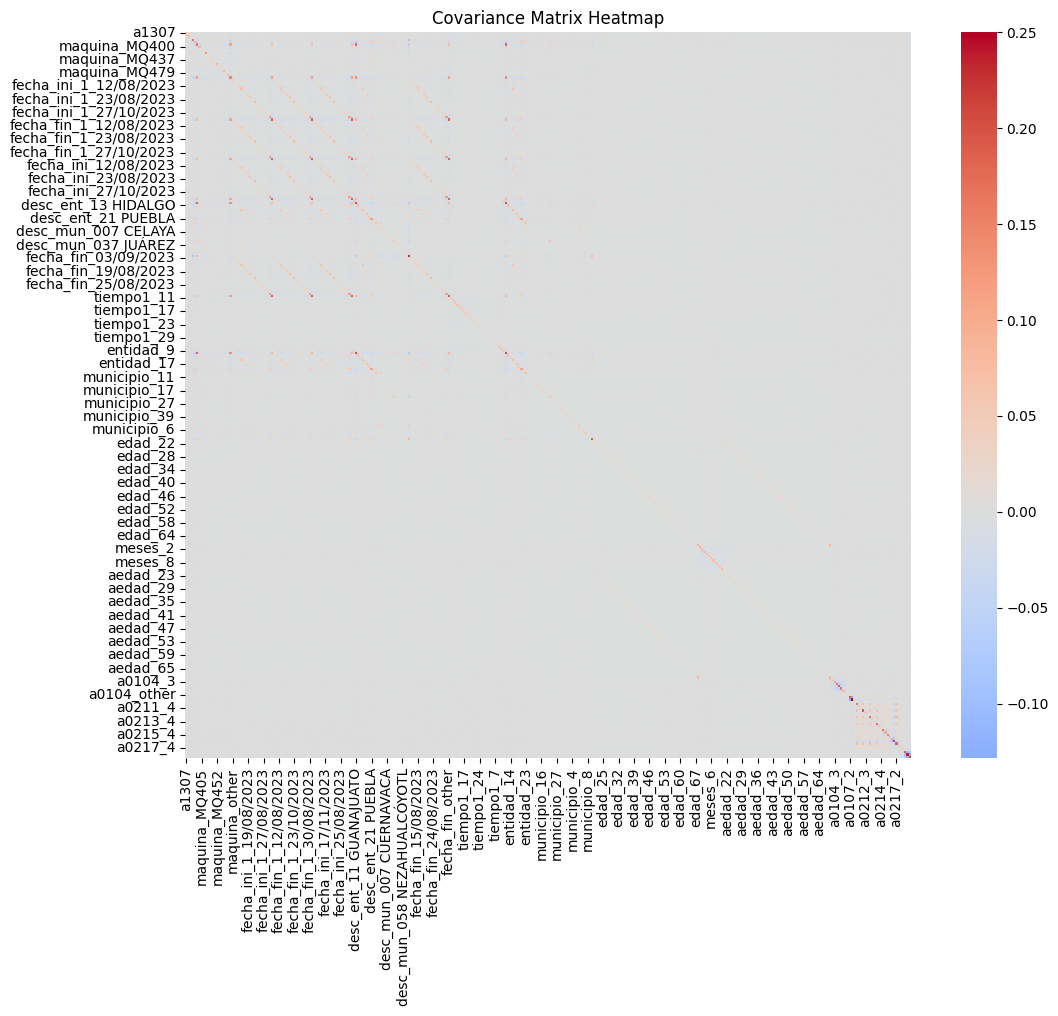

In [23]:
# Assume your data is in a DataFrame called `data_encoded`
cov_matrix = data_encoded.cov()

plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f", square=True)
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
plt.show()


In [8]:
# Compute correlation matrix
corr_matrix = data_encoded.corr().abs()

# Select upper triangle (avoid duplicate pairs)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation above 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop them
df_reduced = data_encoded.drop(columns=to_drop)
print(df_reduced.shape)

(3787, 226)


In [9]:
df_reduced.to_csv("encoded_data.csv", index=False)

In [10]:
!pip install prince

Defaulting to user installation because normal site-packages is not writeable


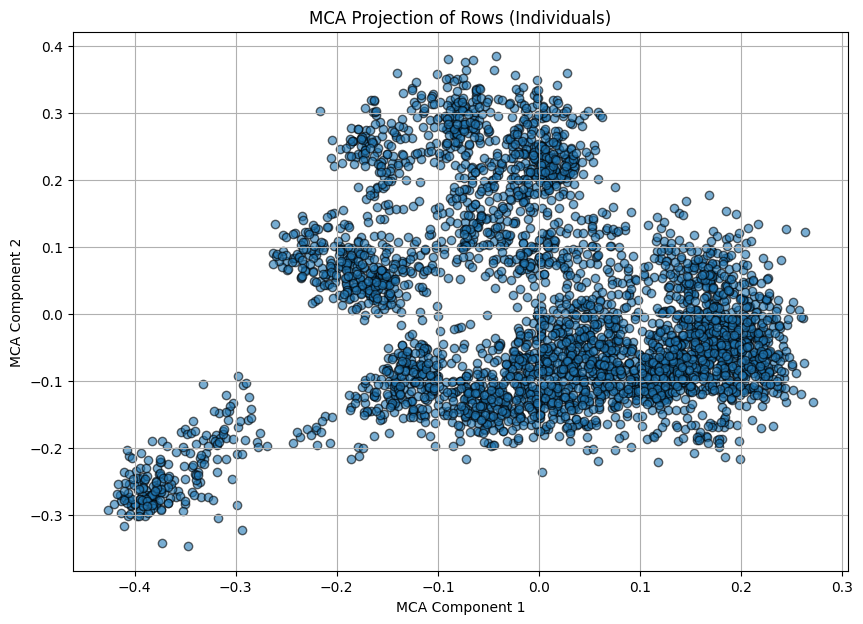

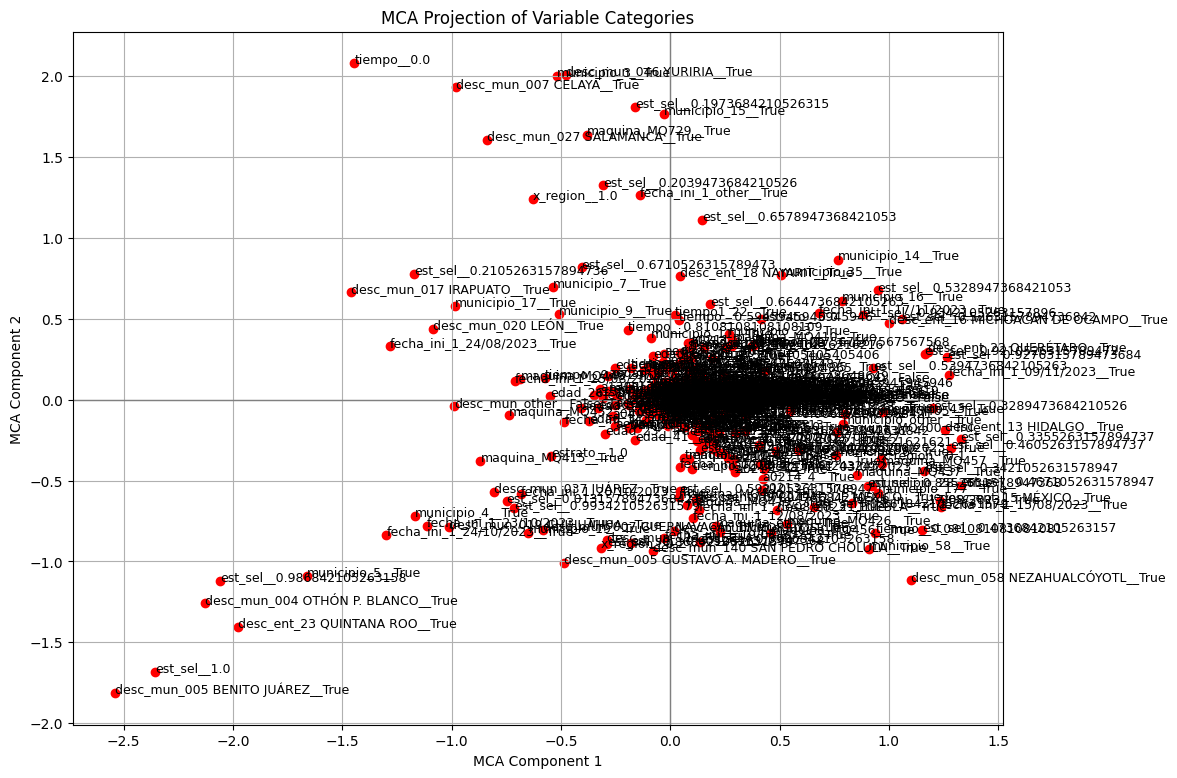

In [11]:
mca = prince.MCA(n_components=30, n_iter=5, copy=True, check_input=True, engine='scipy', random_state=42)
mca = mca.fit(df_reduced)

# Get row coordinates in lower-dimensional space
mca_row_coords = mca.transform(df_reduced)

# Plot the individuals (rows) in MCA space
plt.figure(figsize=(10, 7))
plt.scatter(mca_row_coords[0], mca_row_coords[1], alpha=0.6, edgecolors='k')
plt.title('MCA Projection of Rows (Individuals)')
plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.grid(True)
plt.show()

# Plot variable categories (columns) contribution to the MCA dimensions
# These are called "principal coordinates" of variables in MCA

mca_col_coords = mca.column_coordinates(df_reduced)

plt.figure(figsize=(12, 9))
plt.scatter(mca_col_coords[0], mca_col_coords[1], color='red')

for i, col_name in enumerate(mca_col_coords.index):
    plt.text(mca_col_coords.iloc[i, 0], mca_col_coords.iloc[i, 1], col_name, fontsize=9)

plt.title('MCA Projection of Variable Categories')
plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()



In [12]:
# Percentage of inertia explained by each component
print(dir(mca.svd_))
singular_values = mca.svd_.s  # get singular values vector

explained_inertia = (singular_values ** 2) / (singular_values ** 2).sum()

for i, val in enumerate(explained_inertia, start=1):
    print(f"Component {i}: {val:.4%}")


# For Component 1
top10_comp1 = mca_col_coords[0].abs().sort_values(ascending=False).head(10)
print("Top 10 categories most correlated with MCA Component 1:")
print(top10_comp1)

# For Component 2
top10_comp2 = mca_col_coords[1].abs().sort_values(ascending=False).head(10)
print("\nTop 10 categories most correlated with MCA Component 2:")
print(top10_comp2)

['U', 'V', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 's']
Component 1: 5.6140%
Component 2: 5.3198%
Component 3: 4.8481%
Component 4: 4.7988%
Component 5: 4.5542%
Component 6: 4.2247%
Component 7: 4.1349%
Component 8: 4.1242%
Component 9: 3.8914%
Component 10: 3.8146%
Component 11: 3.6414%
Component 12: 3.3682%
Component 13: 3.2254%
Component 14: 3.1518%
Component 15: 2.9498%
Component 16: 2.8987%
Component 17: 2.8111%
Component 18: 2.7558%
Component 19: 2.6245%
Component 20: 2.6060%
Component 21: 2.5925%
Component 22: 2.5507%
Component 23: 2.5007%
Component 24: 2.4798%
Component 25: 2.4623

In [32]:
#Decided against the use of dimensional reduction for the sake of explainability -> reconstruct into categorical columns (requirement of data analysis)

#print(list(data_encoded.columns))



def reverse_one_hot_with_originals(df, original_cols=data.columns):
    reconstructed = df.copy()
    cols_to_drop = []

    for col_prefix in original_cols:
        matching_cols = [c for c in df.columns if c.startswith(col_prefix + '_')]
        if not matching_cols:
            continue

        max_col = df[matching_cols].idxmax(axis=1)
        categories = max_col.apply(lambda x: x[len(col_prefix) + 1:] if pd.notnull(x) else None)
        reconstructed[col_prefix] = categories

        cols_to_drop.extend(matching_cols)

    # Drop all one-hot columns after processing all prefixes
    reconstructed.drop(columns=cols_to_drop, inplace=True)

    return reconstructed

final_data = reverse_one_hot_with_originals(data_encoded)



In [35]:
cols_to_drop = [col for col in final_data.columns if col.startswith('fecha')] # Time data
final_data = final_data.drop(columns=cols_to_drop)

final_data.to_csv('training_data.csv', index = False)

print(final_data.shape)

(3787, 25)
